# Imports

In [45]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)
warnings.filterwarnings('ignore', message='{ "early_stopping_rounds" } might not be used.')

In [46]:
import numpy as np
import pandas as pd
import random

import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

from pprint import pprint
import os
import os.path as op
import shutil

import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('viridis')
from sklearn.model_selection import train_test_split

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH, list_datasets
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialsation

In [49]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [50]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)
pprint(list_datasets(context))

['/raw/google_search_data',
 '/raw/product_manufacturer_list',
 '/raw/sales_data',
 '/raw/social_media_data',
 '/raw/theme_list',
 '/raw/theme_product_list',
 '/cleaned/google_search_data',
 '/cleaned/product_manufacturer_list',
 '/cleaned/sales_data',
 '/cleaned/social_media_data',
 '/cleaned/theme_list',
 '/cleaned/theme_product_list',
 '/train/train']


In [51]:
train = pd.read_csv('social_google_sales.csv')

In [52]:
train.head()

,Unnamed: 0,year,week,total_post,claim_id,search_volume,sales_dollars_value,sales_units_value,sales_lbs_value
0,0,2016,1,726,8,49214,8853853,1952575,2947044
1,1,2016,2,1180,8,46543,8705721,1921171,2901409
2,2,2016,3,2014,8,44716,8839233,1968251,2954048
3,3,2016,4,1586,8,53664,8872568,1974980,2941180
4,4,2016,5,1357,8,47560,9166248,2092314,3012709


## Modelling

In [57]:
features = train.drop(['Unnamed: 0', 'sales_dollars_value',, 'sales_units_value'], axis = 1).columns
target = 'sales_dollars_value'

In [58]:
features

Index(['year', 'week', 'total_post', 'search_volume', 'sales_lbs_value'], dtype='object')

In [59]:
xgb_params = {'n_estimators': 1500,
              'max_depth' : 10,
              'learning_rate' : 0.1,
              'eval_metric': 'mape',
              'n_jobs': -1 }

sc = StandardScaler()
train[features] = sc.fit_transform(train[features])


In [60]:
k = 10
mape_values = []
kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

for fold, (train_idx, val_idx) in enumerate(kf.split(train[features],train[target])):
    
    print('Fold {}'.format(fold), '-'*75)
    
    X_train, y_train = train.iloc[train_idx][features], train.iloc[train_idx][target]
    X_val, y_val = train.iloc[val_idx][features], train.iloc[val_idx][target]
    
    xgb = XGBRegressor(**xgb_params,
                       early_stopping_rounds = 250,
                       random_state = 42,
                       verbosity = 0
                      )
    
    xgb.fit(X_train, y_train,
           eval_set = [(X_val, y_val)],
           verbose = 1000)
    
    preds = xgb.predict(X_val)
    
    mape = mean_absolute_percentage_error(y_true = y_val, 
                                          y_pred= preds)
    print(f'MAPE: {mape}')
    print()
    mape_values.append(mape)
    
print(f'=== Average MAPE of {fold} Folds: {np.mean(mape_values)}===')   

Fold 0 ---------------------------------------------------------------------------
[0]	validation_0-mape:0.89875
[1000]	validation_0-mape:0.15131
[1499]	validation_0-mape:0.15127
MAPE: 0.15126630715522824

Fold 1 ---------------------------------------------------------------------------
[0]	validation_0-mape:0.89935
[1000]	validation_0-mape:0.21643
[1499]	validation_0-mape:0.21642
MAPE: 0.21641880391458432

Fold 2 ---------------------------------------------------------------------------
[0]	validation_0-mape:0.98726
[1000]	validation_0-mape:0.17230
[1499]	validation_0-mape:0.17634
MAPE: 0.17634413302188368

Fold 3 ---------------------------------------------------------------------------
[0]	validation_0-mape:0.90038
[1000]	validation_0-mape:0.06765
[1499]	validation_0-mape:0.06764
MAPE: 0.06764328140519942

Fold 4 ---------------------------------------------------------------------------
[0]	validation_0-mape:0.90128
[1000]	validation_0-mape:0.07825
[1499]	validation_0-mape:0.078

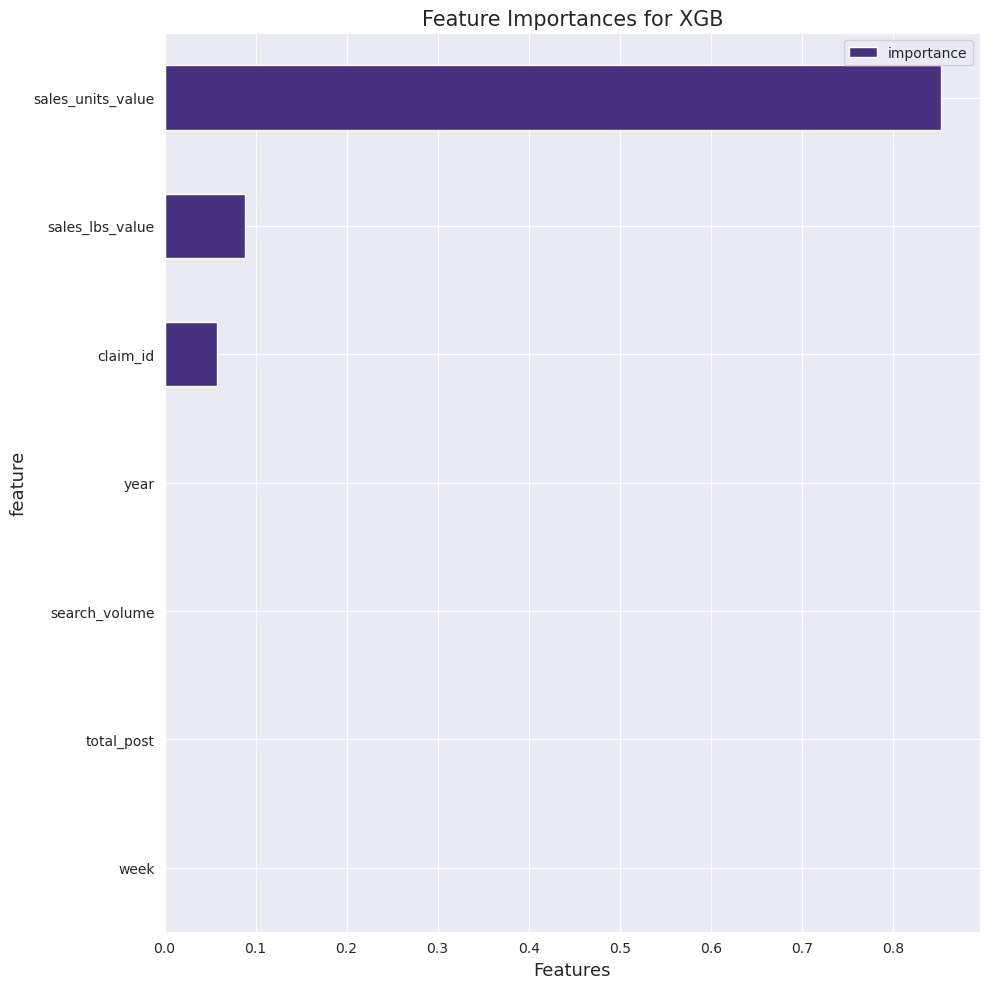

In [39]:
importances = pd.DataFrame({'feature':features, 'importance': np.round(xgb.feature_importances_, 3)})
importances = importances.sort_values('importance').set_index('feature')

fig, axs = plt.subplots(figsize = (10,10))
_ = axs.set_title('Feature Importances for XGB', fontsize = 15)
_ = axs.set_xlabel('Features', fontsize = 13)
_ = axs.set_ylabel('Importance', fontsize = 13)

importances.plot.barh(ax = axs)
plt.savefig("./artifacts/xgb_baseline_importances.png")